## Compare the observed and synthetic transmission spectra longward of 2 micrometres

In [1]:
import warnings
from pathlib import Path

import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.const import init_const
from aeolus.coord import roll_cube_pm180
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator
from aeolus.synthobs import (
    calc_stellar_flux,
    read_normalized_stellar_flux,
    read_spectral_bands,
)

In [3]:
from util_commons import CIA, GASES, PLANETS, SUITES
from util_mypaths import (
    path_to_constants,
    path_to_data_umserve,
    path_to_obs,
    path_to_results,
)
from util_plot_func import use_paper_style

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
use_paper_style()

In [5]:
def calc_transmission_spectrum_day_night_average(
    spectral_file,
    stellar_constant_at_1_au,
    stellar_radius,
    planet_top_of_atmosphere,
    planet_transmission_day,
    planet_transmission_night,
    model=um,
):
    r"""
    Calculate the synthetic transmission spectrum averaged over the dayside and the nightside.

    Parameters
    ----------
    spectral_file: pathlib.PosixPath
        Path to the location of a SOCRATES spectral file.
    stellar_constant_at_1_au: float or iris.cube.Cube
        Stellar constant at 1 AU [W m-2].
    stellar_radius: float or iris.cube.Cube
        Stellar radius [m].
    planet_top_of_atmosphere: float or iris.cube.Cube
        The extent of the planetary atmosphere [m].
    planet_transmission_day: iris.cube.Cube
        Met Office Unified Model output of STASH item m01s01i755
        (in the case of hot Jupiters) from the dayside calculation.
    planet_transmission_night: iris.cube.Cube
        Met Office Unified Model output of STASH item m01s01i755
        (in the case of hot Jupiters) from the nightside calculation.
    model: aeolus.model.Model, optional
        Model class with relevant variable names.

    Returns
    -------
    numpy.ndarray
        Spectral band centers [m].
    iris.cube.Cube
        The ratio of the effective planetary radius to the stellar radius per spectral band [1].

    Notes
    -------
    The transmission spectrum is the ratio of the effective planetary radius to the stellar
    radius calculated per spectral band:

    .. math::

        \frac{R_p (\nu)}{R_s} = \sqrt{(\frac{R_{p,TOA}}{R_s})^2 -
         \frac{\sum_{lat,lon}^{}F_{transmitted} (\nu)}{F_{stellar} (\nu)}}

    where
    :math:`R_p(\nu)` is the effective planetary radius,
    :math:`R_s` is the stellar radius,
    :math:`R_{p,TOA}` is the extent of the planetary atmosphere (which usually is the sum of
    the planetary radius and the height of the model domain),
    :math:`\sum_{lat,lon}^{}F_{transmitted}(\nu)` is the total transmitted flux,
    :math:`F_{stellar}(\nu)` is the stellar flux.
    """
    # Ensure that input constants are iris cubes
    if not isinstance(stellar_constant_at_1_au, iris.cube.Cube):
        stellar_constant_at_1_au = iris.cube.Cube(
            stellar_constant_at_1_au,
            long_name="stellar_constant_at_1_au",
            units="W m-2",
        )
    if not isinstance(stellar_radius, iris.cube.Cube):
        stellar_radius = iris.cube.Cube(
            stellar_radius,
            long_name="stellar_radius",
            units="m",
        )
    if not isinstance(planet_top_of_atmosphere, iris.cube.Cube):
        planet_top_of_atmosphere = iris.cube.Cube(
            planet_top_of_atmosphere,
            long_name="planet_top_of_atmosphere",
            units="m",
        )

    # Load UM output from the dayside calculation
    day = planet_transmission_day
    day_lon_coord = day.coord(um.x)

    # Load UM output from the nightside calculation
    # Roll nightside data by 180 degrees
    night_rolled = roll_cube_pm180(planet_transmission_night)
    # Reverse longitude order (turned out to be not needed)
    # night = reverse(night_rolled, night_rolled.coord_dims(um.x))
    night = night_rolled
    # Replace the longitude coordinate to be able to do maths with iris
    night.replace_coord(day_lon_coord)

    # Use the same name for the spectral band index coordinate
    for coord in day.coords():
        if coord.name() in ["pseudo", "pseudo_level"]:
            coord.rename("spectral_band_index")
    for coord in night.coords():
        if coord.name() in ["pseudo", "pseudo_level"]:
            coord.rename("spectral_band_index")

    # Calculate the geometric mean of the dayside and nightside transmitted flux
    # and sum this flux over all latitudes and longitudes
    transmitted_flux = ((day * night) ** (0.5)).collapsed([um.y, um.x], iris.analysis.SUM)
    transmitted_flux.rename("total_transmitted_flux")
    transmitted_flux.units = "W m-2"

    # Calculate stellar flux
    stellar_flux = calc_stellar_flux(spectral_file, stellar_constant_at_1_au)

    # Calculate the ratio of the total transmitted flux to the stellar flux
    flux_ratio = transmitted_flux.copy(data=transmitted_flux.core_data() / stellar_flux.core_data())
    flux_ratio.rename("flux_ratio")
    flux_ratio.units = transmitted_flux.units / stellar_flux.units

    # Calculate the ratio of the effective planetary radius to the stellar radius
    rp_eff_over_rs_squared = (planet_top_of_atmosphere / stellar_radius) ** 2 - flux_ratio
    rp_eff_over_rs_squared.data[rp_eff_over_rs_squared.data < 0.0] = 0.0
    rp_eff_over_rs = rp_eff_over_rs_squared ** (0.5)
    rp_eff_over_rs.rename("radius_ratio")

    # Find spectral band centers
    spectral_bands = read_spectral_bands(spectral_file)
    spectral_band_centers = 0.5 * (
        spectral_bands["lower_wavelength_limit"] + spectral_bands["upper_wavelength_limit"]
    )

    return spectral_band_centers, rp_eff_over_rs

#### Load the observed transmission spectra

In [6]:
# Load the observed transmission spectra (downloaded on 220324 from the NASA Exoplanet Archive)
path_to_obs_transmission = (
    path_to_obs / "nasa_exoplanet_archive" / "transitspec_2022.03.24_02.50.07.csv"
)
obs = pd.read_csv(path_to_obs_transmission, header=28)

In [7]:
# Organise the observed data by reference
# Ignore the observed data shortward of 2 micrometers as UM spectral files were cut off shortward of 2 micrometers
obs_dict = {
    "hatp11b": {
        "Fraine2014": obs.loc[
            (obs.plntname == "HAT-P-11 b") & (obs.plntranreflink.str.contains("Fraine et al. 2014"))
        ]
    },  # 0.642-1.680; 3.521, 4.471; plntransdep notNaN plnratror NaN; Extended Data Table 1
    "hd189733b": {
        "Desert2011": obs.loc[
            (obs.plntname == "HD 189733 b")
            & (obs.plntranreflink.str.contains("Desert et al. 2011"))
        ],  # 3.6; plntransdep NaN plnratror notNaN; Table 2; reanalaysed in Pont2013
        "Pont2013": obs.loc[
            (obs.plntname == "HD 189733 b") & (obs.plntranreflink.str.contains("Pont et al. 2013"))
        ],  # 0.3300-1.9510, 2.0090-2.4680; 3.6, 4.5, 5.8, 7.85, 24; plntransdep NaN plnratror notNaN; Table 5
        "Gibson2012": obs.loc[
            (obs.plntname == "HD 189733 b")
            & (obs.plntranreflink.str.contains("Gibson et al. 2012"))
        ],  # 1.134, 1.105, 1.607, 1.593; plntransdep NaN plnratror notNaN; < 2 micrometers
        "Sing2011": obs.loc[
            (obs.plntname == "HD 189733 b") & (obs.plntranreflink.str.contains("Sing et al. 2011"))
        ],  # 0.330, 0.395, 0.445, 0.495, 0.545; plntransdep NaN plnratror notNaN; < 2 micrometers
        "Wyttenbach2015": obs.loc[
            (obs.plntname == "HD 189733 b")
            & (obs.plntranreflink.str.contains("Wyttenbach et al. 2015"))
        ],  # 0.5893; plntransdep notNaN plnratror NaN; < 2 micrometers
        "DiGloria2015": obs.loc[
            (obs.plntname == "HD 189733 b")
            & (obs.plntranreflink.str.contains("Di Gloria et al. 2015"))
        ],  # 0.395-0.675; plntransdep NaN plnratror notNaN; < 2 micrometers
        "Swain2008": obs.loc[
            (obs.plntname == "HD 189733 b") & (obs.plntranreflink.str.contains("Swain et al. 2008"))
        ],  # 1.484-2.463; plntransdep notNaN plnratror NaN; Supplementary Table 1
        "Angerhausen2015": obs.loc[
            (obs.plntname == "HD 189733 b")
            & (obs.plntranreflink.str.contains("Angerhausen et al. 2015"))
        ],  # 0.4407, 0.9222; plntransdep NaN plnratror notNaN; < 2 micrometers
        "Sing2016": obs.loc[
            (obs.plntname == "HD 189733 b") & (obs.plntranreflink.str.contains("Sing et al. 2016"))
        ],  # 0.3450-1.9250, 2.3000, 3.5500, 4.5000; plntransdep NaN plnratror notNaN; Figure 1
        "Borsa2016": obs.loc[
            (obs.plntname == "HD 189733 b") & (obs.plntranreflink.str.contains("Borsa et al. 2016"))
        ],  # 0.410-0.675; plntransdep NaN plnratror notNaN; < 2 micrometers
        "Barnes2016": obs.loc[
            (obs.plntname == "HD 189733 b")
            & (obs.plntranreflink.str.contains("Barnes et al. 2016"))
        ],  # 0.3934-0.6563; plntransdep notNaN plnratror NaN; < 2 micrometers
        "McCullough2014": obs.loc[
            (obs.plntname == "HD 189733 b")
            & (obs.plntranreflink.str.contains("McCullough et al. 2014"))
        ],  # 1.1279-1.6350; plntransdep notNaN plnratror NaN; < 2 micrometers
    },
    "hd209458b": {
        "Evans2015": obs.loc[
            (obs.plntname == "HD 209458 b") & (obs.plntranreflink.str.contains("Evans et al. 2015"))
        ],  # 3.6, 4.5, 5.8, 8.0; plntransdep NaN plnratror notNaN; Table 4
        "Deming2013": obs.loc[
            (obs.plntname == "HD 209458 b")
            & (obs.plntranreflink.str.contains("Deming et al. 2013"))
        ],  # 1.119-1.628; plntransdep notNaN plnratror NaN; < 2 micrometers
        "Sing2016": obs.loc[
            (obs.plntname == "HD 209458 b") & (obs.plntranreflink.str.contains("Sing et al. 2016"))
        ],  # 0.3072-1.6391, 3.5600, 4.5000; plntransdep NaN plnratror notNaN; Figure 1
    },
    "wasp17b": {
        "Bento2014": obs.loc[
            (obs.plntname == "WASP-17 b") & (obs.plntranreflink.str.contains("Bento et al. 2014"))
        ],  # 0.365-0.658; plntransdep NaN plnratror notNaN; < 2 micrometers
        "Mandell2013": obs.loc[
            (obs.plntname == "WASP-17 b") & (obs.plntranreflink.str.contains("Mandell et al. 2013"))
        ],  # 1.128-1.634; plntransdep notNaN plnratror NaN; < 2 micrometers
        "Wood2011": obs.loc[
            (obs.plntname == "WASP-17 b") & (obs.plntranreflink.str.contains("Wood et al. 2011"))
        ],  # 0.5890-0.5896; plntransdep notNaN plnratror NaN; < 2 micrometers
        "Sing2016": obs.loc[
            (obs.plntname == "WASP-17 b") & (obs.plntranreflink.str.contains("Sing et al. 2016"))
        ],  # 0.3400-1.6423, 3.5600, 4.5000; plntransdep NaN plnratror notNaN; Figure 1
        "Sedaghati2016": obs.loc[
            (obs.plntname == "WASP-17 b")
            & (obs.plntranreflink.str.contains("Sedaghati et al. 2016"))
        ],  # 0.575-0.795; plntransdep NaN plnratror notNaN; < 2 micrometers
    },
}
# HAT-P-11b Chachan2019 Table 2 as rp_over_rs
chachan2019 = {
    "hatp11b": {
        "wavelength": [3.6, 4.5],
        "rp_over_rs_sqrd": [0.05778 ** 2, 0.05811 ** 2],
        "rp_over_rs_sqrd_minus": [0.00026 * 2 * 0.05778, 0.00027 * 2 * 0.05811], # with error propagation
        "rp_over_rs_sqrd_plus": [0.00024 * 2 * 0.05778, 0.00028 * 2 * 0.05811],
    }
}
# HD 209458b Evans2015 Table 4 as rp_over_rs, points missing from the NASA Exoplanet Archive
evans2015 = {
    "hd209458b": {
        "wavelength": [3.6, 3.6],
        "rp_over_rs_sqrd": [0.11354 ** 2, 0.11919 ** 2],
        "rp_over_rs_sqrd_minus": [0.00087 * 2 * 0.11354, 0.00032 * 2 * 0.11919], # with error propagation
        "rp_over_rs_sqrd_plus": [0.00085 * 2 * 0.11354, 0.00032 * 2 * 0.11919],
    }
}
# WASP-17b Alderson2022 Table 3 as transit depth in %
alderson2022 = {
    "wasp17b": {
        "wavelength": [3.6, 4.5],
        "rp_over_rs_sqrd": [1.5177 * 1e-2, 1.5679 * 1e-2],
        "rp_over_rs_sqrd_minus": [0.0123 * 1e-2, 0.0149 * 1e-2], # no need for error propagation
        "rp_over_rs_sqrd_plus": [0.0123 * 1e-2, 0.0149 * 1e-2],
    }
}

#### Calculate the day-nightside average synthetic transmission spectra using the UM data

In [8]:
# UM parameters
metallicity = "solar"

hatp11b_const = init_const("hatp11b", directory=path_to_constants)
hd189733b_const = init_const("hd189733b", directory=path_to_constants)
hd209458b_const = init_const("hd209458b", directory=path_to_constants)
wasp17b_const = init_const("wasp17b", directory=path_to_constants)
PLANET_CONSTS = [hatp11b_const, hd189733b_const, hd209458b_const, wasp17b_const]

sps = ["total", "ch4", "co", "co2", "h2o", "hcn", "nh3", "h2_h2_cia", "h2_he_cia"]

In [9]:
# For checking "day" vs "night" UM transmission spectrum calculation
# planet, exp = "wasp17b", "equilibrium"
# a = iris.load_cube(str(SUITES[planet][exp][metallicity]["dir_for_transmission_day_h2_he_cia"]))
# b = iris.load_cube(str(SUITES[planet][exp][metallicity]["dir_for_transmission_night_h2_he_cia"]))
# qplt.contourf(a[100, :, ...]);
# qplt.contourf(b[100, :, ...]);

In [10]:
# Calculate UM transmission spectra (total and contributions from individual opacity sources)
vrbls = {}
for planet, planet_const in zip(PLANETS.keys(), PLANET_CONSTS):
    vrbls[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        vrbls[planet][exp] = {}
        for sp in tqdm(sps):
            in_dict = {
                "spectral_file": SUITES[planet][exp][metallicity]["dir_for_star_spectrum_sw"],
                "star_constant_at_1_au": planet_const.star_constant_at_1_au,
                "star_radius": planet_const.star_radius,
                "planet_top_of_atmosphere": (
                    planet_const.planet_radius + planet_const.planet_domain_height
                ),
                "planet_transmission_day": iris.load_cube(
                    str(SUITES[planet][exp][metallicity][f"dir_for_transmission_day_{sp}"])
                ),
                "planet_transmission_night": iris.load_cube(
                    str(SUITES[planet][exp][metallicity][f"dir_for_transmission_night_{sp}"])
                ),
            }
            spectral_band_centers, rp_eff_over_rs = calc_transmission_spectrum_day_night_average(
                *[value for key, value in in_dict.items()]
            )
            vrbls[planet][exp][sp] = {
                "spectral_band_centers": spectral_band_centers,
                "rp_eff_over_rs": rp_eff_over_rs,
            }

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

#### Plot the comparision

In [11]:
# Plotting options
xticks = np.concatenate(
    [
        np.arange(2, 10, 1),
        np.array([10, 15, 20, 30]),
    ]
)
# refs: references from the NASA Exoplanet Archive selected for plotting
# markers: markers for the references above
# ylim: y axis limits
# um_shift: by how much UM data is shifted to match the latest observed data at 4.5 micrometers (Chachan2019 and Sing2016)
plt_kws = {
    "hatp11b": {
        "refs": ["Fraine2014"],
        "markers": ["s"],
        "ylims": (0.0032, 0.0038),
        "um_shift": -0.00076,
    },
    "hd189733b": {
        "refs": ["Swain2008", "Pont2013", "Sing2016"],  # "Desert2011",
        "markers": ["v", "o", "D"],  # "s",
        "ylims": (0.0236, 0.0246),
        "um_shift": -0.00098,
    },
    "hd209458b": {
        "refs": ["Evans2015", "Sing2016"],
        "markers": ["o", "D"],
        "ylims": (0.014, 0.015),  # for 4 points at 3.6 micrometers from Evans2015 (0.0125, 0.015)
        "um_shift": 0.00014,
    },
    "wasp17b": {
        "refs": ["Sing2016"],
        "markers": ["D"],
        "ylims": (0.0140, 0.0165),
        "um_shift": -0.0072,
    },
}

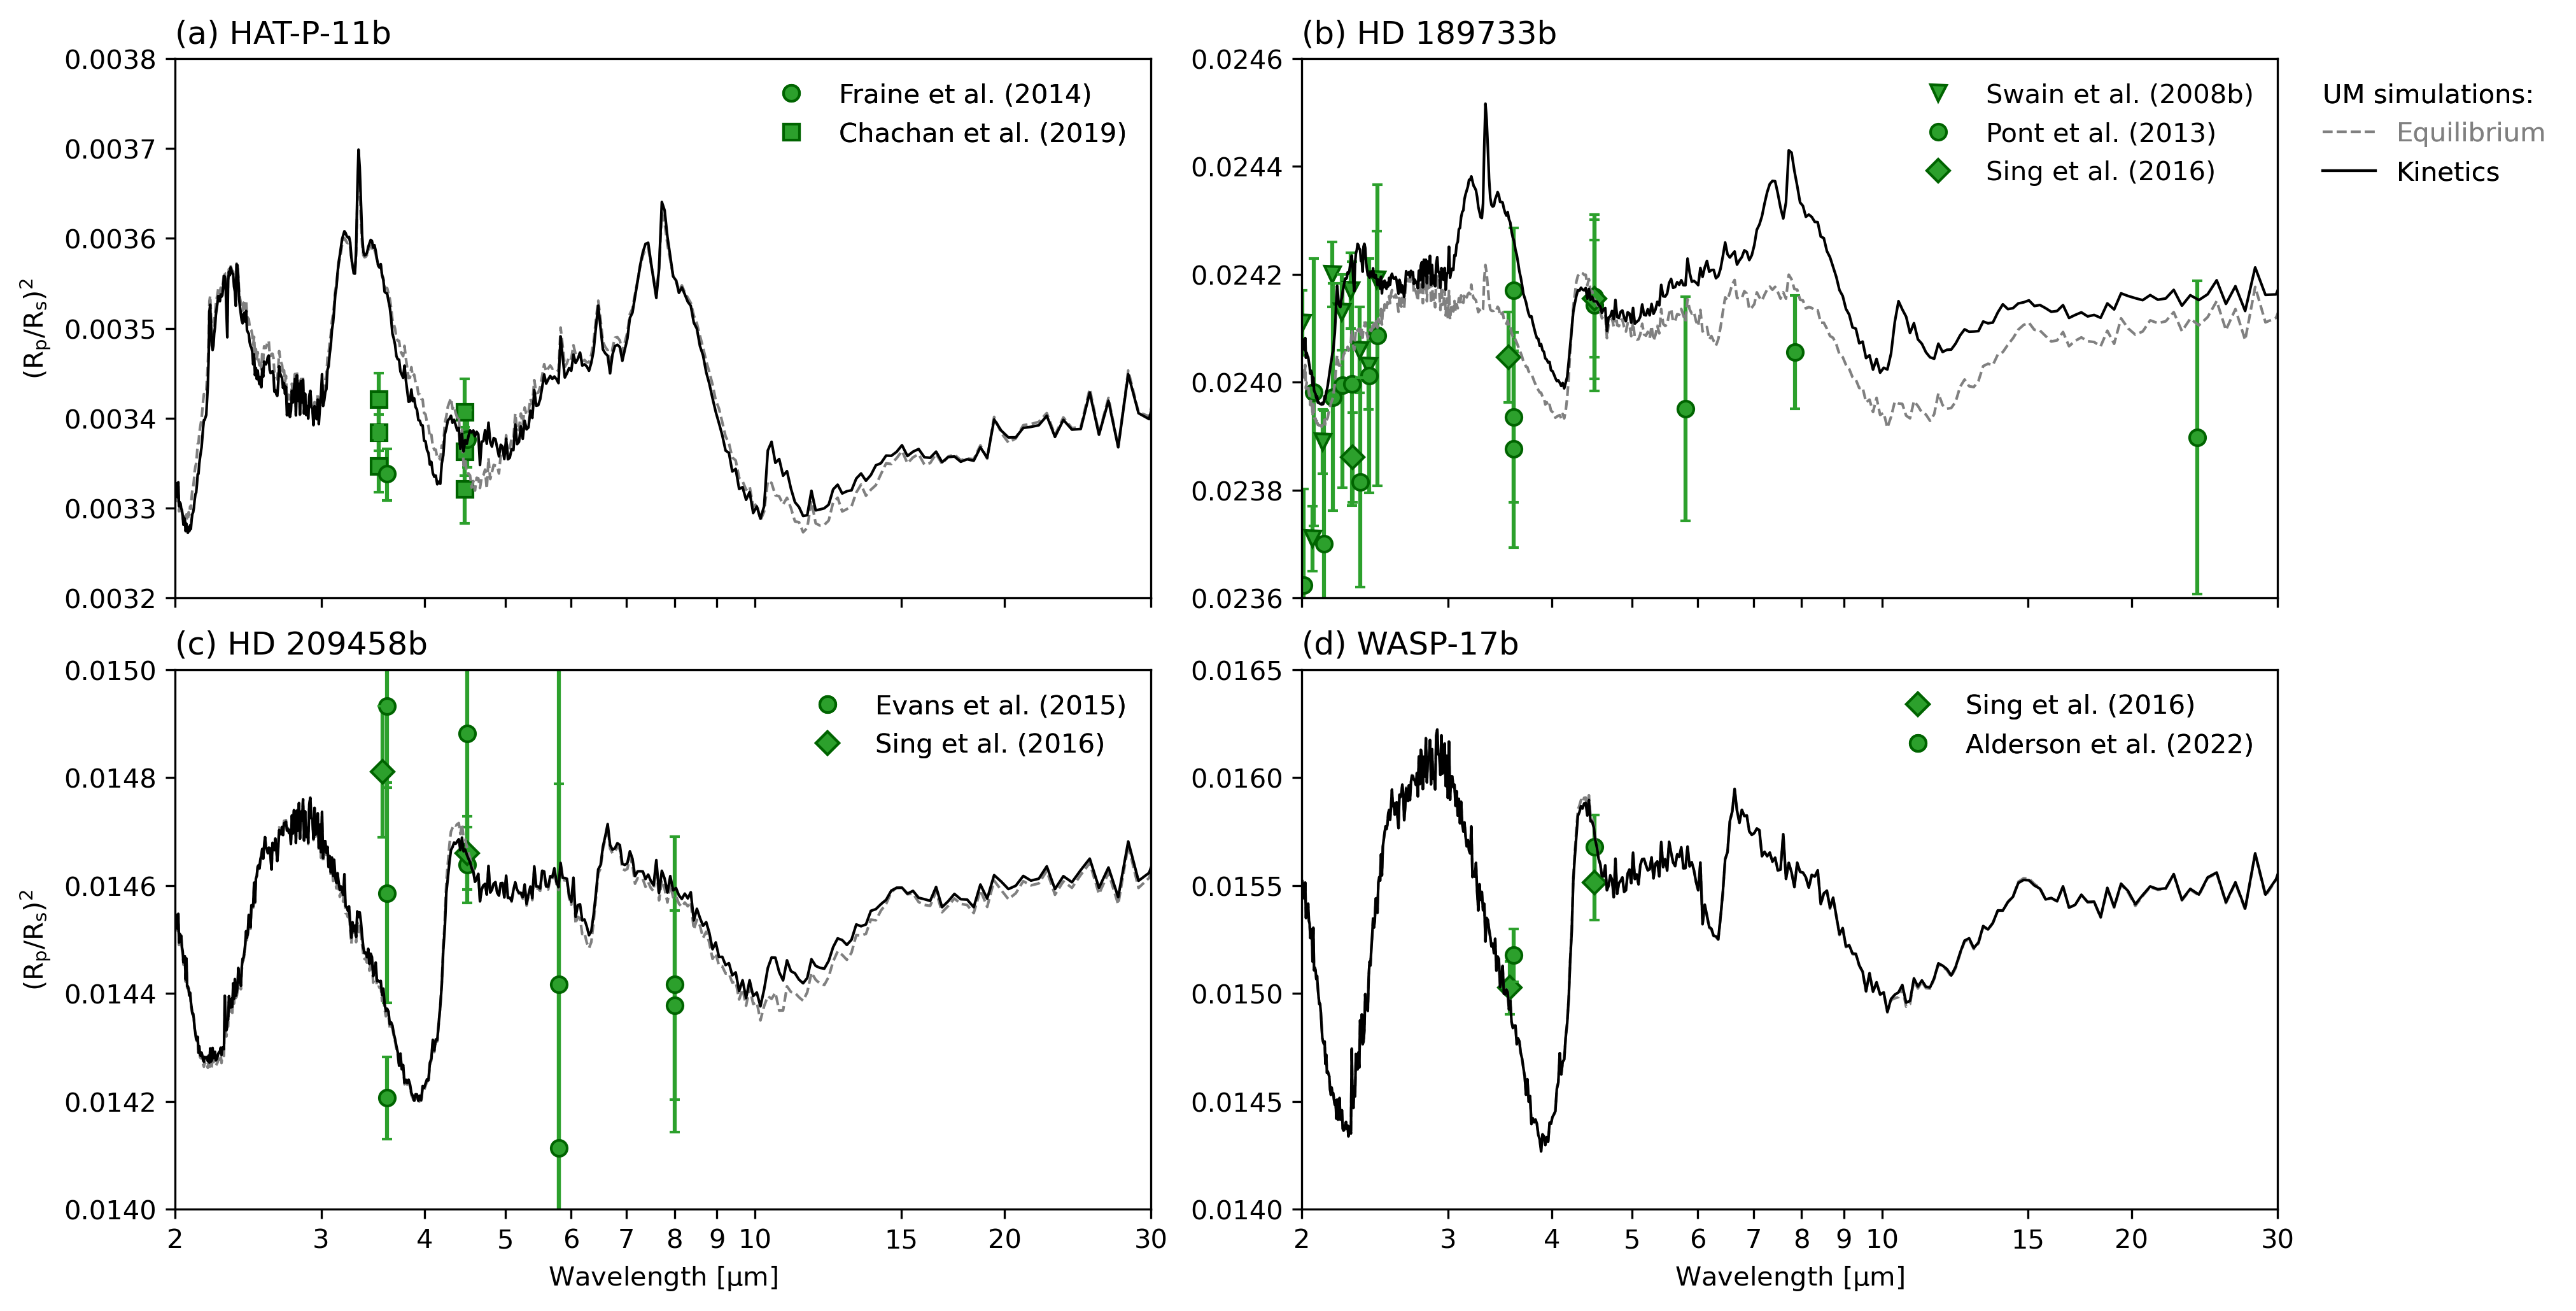

In [15]:
# Plot the observed and UM transmission spectra
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6.75), constrained_layout=True, sharex=True)
iletters = subplot_label_generator()
for planet, ax in zip(PLANETS.keys(), axes.flatten()):
    ax.set_title(f'({next(iletters)}) {PLANETS[planet]["tex"]}', loc="left")

    # Add observational data from the NASA Exoplanet Archive
    for ref, marker in zip(plt_kws[planet]["refs"], plt_kws[planet]["markers"]):
        # Check if rp_over_rs**2 or rp_over_rs data are available
        for i in obs_dict[planet][ref].plntransdep.values:
            if np.isnan(i):
                pass  # print(ref, ": no rp_over_rs**2 data.")
            else:
                x = obs_dict[planet][ref].centralwavelng
                y = obs_dict[planet][ref].plntransdep * 1e-2
                # No need for error propagation
                yerr_minus = obs_dict[planet][ref].plntransdeperr2 * (-1) * 1e-2 
                yerr_plus = obs_dict[planet][ref].plntransdeperr1 * 1e-2
                yerr = np.vstack((yerr_minus, yerr_plus))
        for i in obs_dict[planet][ref].plnratror.values:
            if np.isnan(i):
                pass  # print(ref, ": no rp_over_rs data.")
            else:
                if ref != "Desert2011":  # exclude Desert2011 because reanalysed by Pont2013
                    x = obs_dict[planet][ref].centralwavelng
                    y = obs_dict[planet][ref].plnratror ** 2
                    # With error propagation
                    yerr_minus = np.array(obs_dict[planet][ref].plnratrorerr2) * 2 * np.array(obs_dict[planet][ref].plnratror) * (-1)
                    yerr_plus = np.array(obs_dict[planet][ref].plnratrorerr1) * 2 * np.array(obs_dict[planet][ref].plnratror) 
                    yerr = np.vstack((yerr_minus, yerr_plus))
        ax.plot(x, y, marker=marker, linestyle="", color="C2", markeredgecolor="darkgreen")
        ax.errorbar(x, y, yerr=yerr, linestyle="", color="C2", capsize=2)
    # Add observational data from other sources
    if planet == "hatp11b":
        hatp11b_plt_kw = {
            "Fraine et al. (2014)": {
                "color": "C2",
                "linestyle": "",
                "marker": "o",
                "markeredgecolor": "darkgreen",
            },
            "Chachan et al. (2019)": {
                "color": "C2",
                "linestyle": "",
                "marker": "s",
                "markeredgecolor": "darkgreen",
            },
        }
        x = chachan2019[planet]["wavelength"]
        y = chachan2019[planet]["rp_over_rs_sqrd"]
        yerr_minus = chachan2019[planet]["rp_over_rs_sqrd_minus"]
        yerr_plus = chachan2019[planet]["rp_over_rs_sqrd_plus"]
        yerr = np.vstack((yerr_minus, yerr_plus))
        ax.plot(x, y, marker="o", linestyle="", color="C2", markeredgecolor="darkgreen")
        ax.errorbar(x, y, yerr=yerr, linestyle="", color="C2", capsize=2)
        add_custom_legend(ax, hatp11b_plt_kw, frameon=False, loc="upper right")
    if planet == "hd189733b":
        hd189733b_plt_kw = {
            "Swain et al. (2008b)": {
                "color": "C2",
                "linestyle": "",
                "marker": "v",
                "markeredgecolor": "darkgreen",
            },
            "Pont et al. (2013)": {
                "color": "C2",
                "linestyle": "",
                "marker": "o",
                "markeredgecolor": "darkgreen",
            },
            "Sing et al. (2016)": {
                "color": "C2",
                "linestyle": "",
                "marker": "D",
                "markeredgecolor": "darkgreen",
            },
        }
        add_custom_legend(ax, hd189733b_plt_kw, frameon=False, loc="upper right")
    if planet == "hd209458b":
        hd209458b_plt_kw = {
            "Evans et al. (2015)": {
                "color": "C2",
                "linestyle": "",
                "marker": "o",
                "markeredgecolor": "darkgreen",
            },
            "Sing et al. (2016)": {
                "color": "C2",
                "linestyle": "",
                "marker": "D",
                "markeredgecolor": "darkgreen",
            },
        }
        x = evans2015[planet]["wavelength"]
        y = evans2015[planet]["rp_over_rs_sqrd"]
        yerr_minus = np.array(evans2015[planet]["rp_over_rs_sqrd_minus"])
        yerr_plus = np.array(evans2015[planet]["rp_over_rs_sqrd_plus"])
        yerr = np.vstack((yerr_minus, yerr_plus))
        ax.plot(x, y, marker="o", linestyle="", color="C2", markeredgecolor="darkgreen")
        ax.errorbar(x, y, yerr=yerr, linestyle="", color="C2", capsize=2)
        add_custom_legend(ax, hd209458b_plt_kw, frameon=False, loc="upper right")
    if planet == "wasp17b":
        wasp17b_plt_kw = {
            "Sing et al. (2016)": {
                "color": "C2",
                "linestyle": "",
                "marker": "D",
                "markeredgecolor": "darkgreen",
            },
            "Alderson et al. (2022)": {
                "color": "C2",
                "linestyle": "",
                "marker": "o",
                "markeredgecolor": "darkgreen",
            },
        }
        x = alderson2022[planet]["wavelength"]
        y = alderson2022[planet]["rp_over_rs_sqrd"]
        yerr_minus = alderson2022[planet]["rp_over_rs_sqrd_minus"]
        yerr_plus = alderson2022[planet]["rp_over_rs_sqrd_plus"]
        yerr = np.vstack((yerr_minus, yerr_plus))
        ax.plot(x, y, marker="o", linestyle="", color="C2", markeredgecolor="darkgreen")
        ax.errorbar(x, y, yerr=yerr, linestyle="", color="C2", capsize=2)
        add_custom_legend(ax, wasp17b_plt_kw, frameon=False, loc="upper right")

    # Add UM data
    for exp, clr, linestyle in zip(["equilibrium", "kinetics"], ["grey", "k"], ["dashed", "solid"]):
        spectral_band_centers = vrbls[planet][exp]["total"]["spectral_band_centers"]
        rp_eff_over_rs = vrbls[planet][exp]["total"]["rp_eff_over_rs"]
        ax.plot(
            spectral_band_centers * 1e6,
            rp_eff_over_rs.data.squeeze() ** 2 + plt_kws[planet]["um_shift"],
            label=None,
            color=clr,
            linestyle=linestyle,
            linewidth=1,
        )
    ax.set_xscale("log")
    ax.set_xlim(2, 30)  # (0.5, 7.8) Ariel, 0.6, 28.3 JWST
    ax.set_ylim(plt_kws[planet]["ylims"])
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Wavelength [$\mu$m]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("($R_p/R_s)^2$")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)  # comment out when using widgets

# Add UM experiments legend
leg_exp_styles = {
    "equilibrium".capitalize(): {"linestyle": "dashed", "linewidth": 1, "color": "grey"},
    "kinetics".capitalize(): {"linestyle": "solid", "linewidth": 1, "color": "k"},
}
leg_exp_kw = {
    "frameon": False,
    "loc": "upper right",
    "bbox_to_anchor": (1.3, 1),
    "title": "UM simulations:",
}
lines_exp = [Line2D([0], [0], **style) for style in leg_exp_styles.values()]
leg_exp = axes[0, 1].legend(lines_exp, leg_exp_styles.keys(), **leg_exp_kw)
if axes[0, 1].legend_ is not None:
    axes[0, 1].add_artist(leg_exp)
for line, text in zip(leg_exp.get_lines(), leg_exp.get_texts()):
    text.set_color(line.get_color())
leg_exp._legend_box.align = "left"

figname = f"transmission_daynight_2_30_micron_total_w_obs_co_as_center_w_error_propagation.png"
fig.savefig(path_to_results / "synthetic_observations" / "transmission_spectrum" / figname)

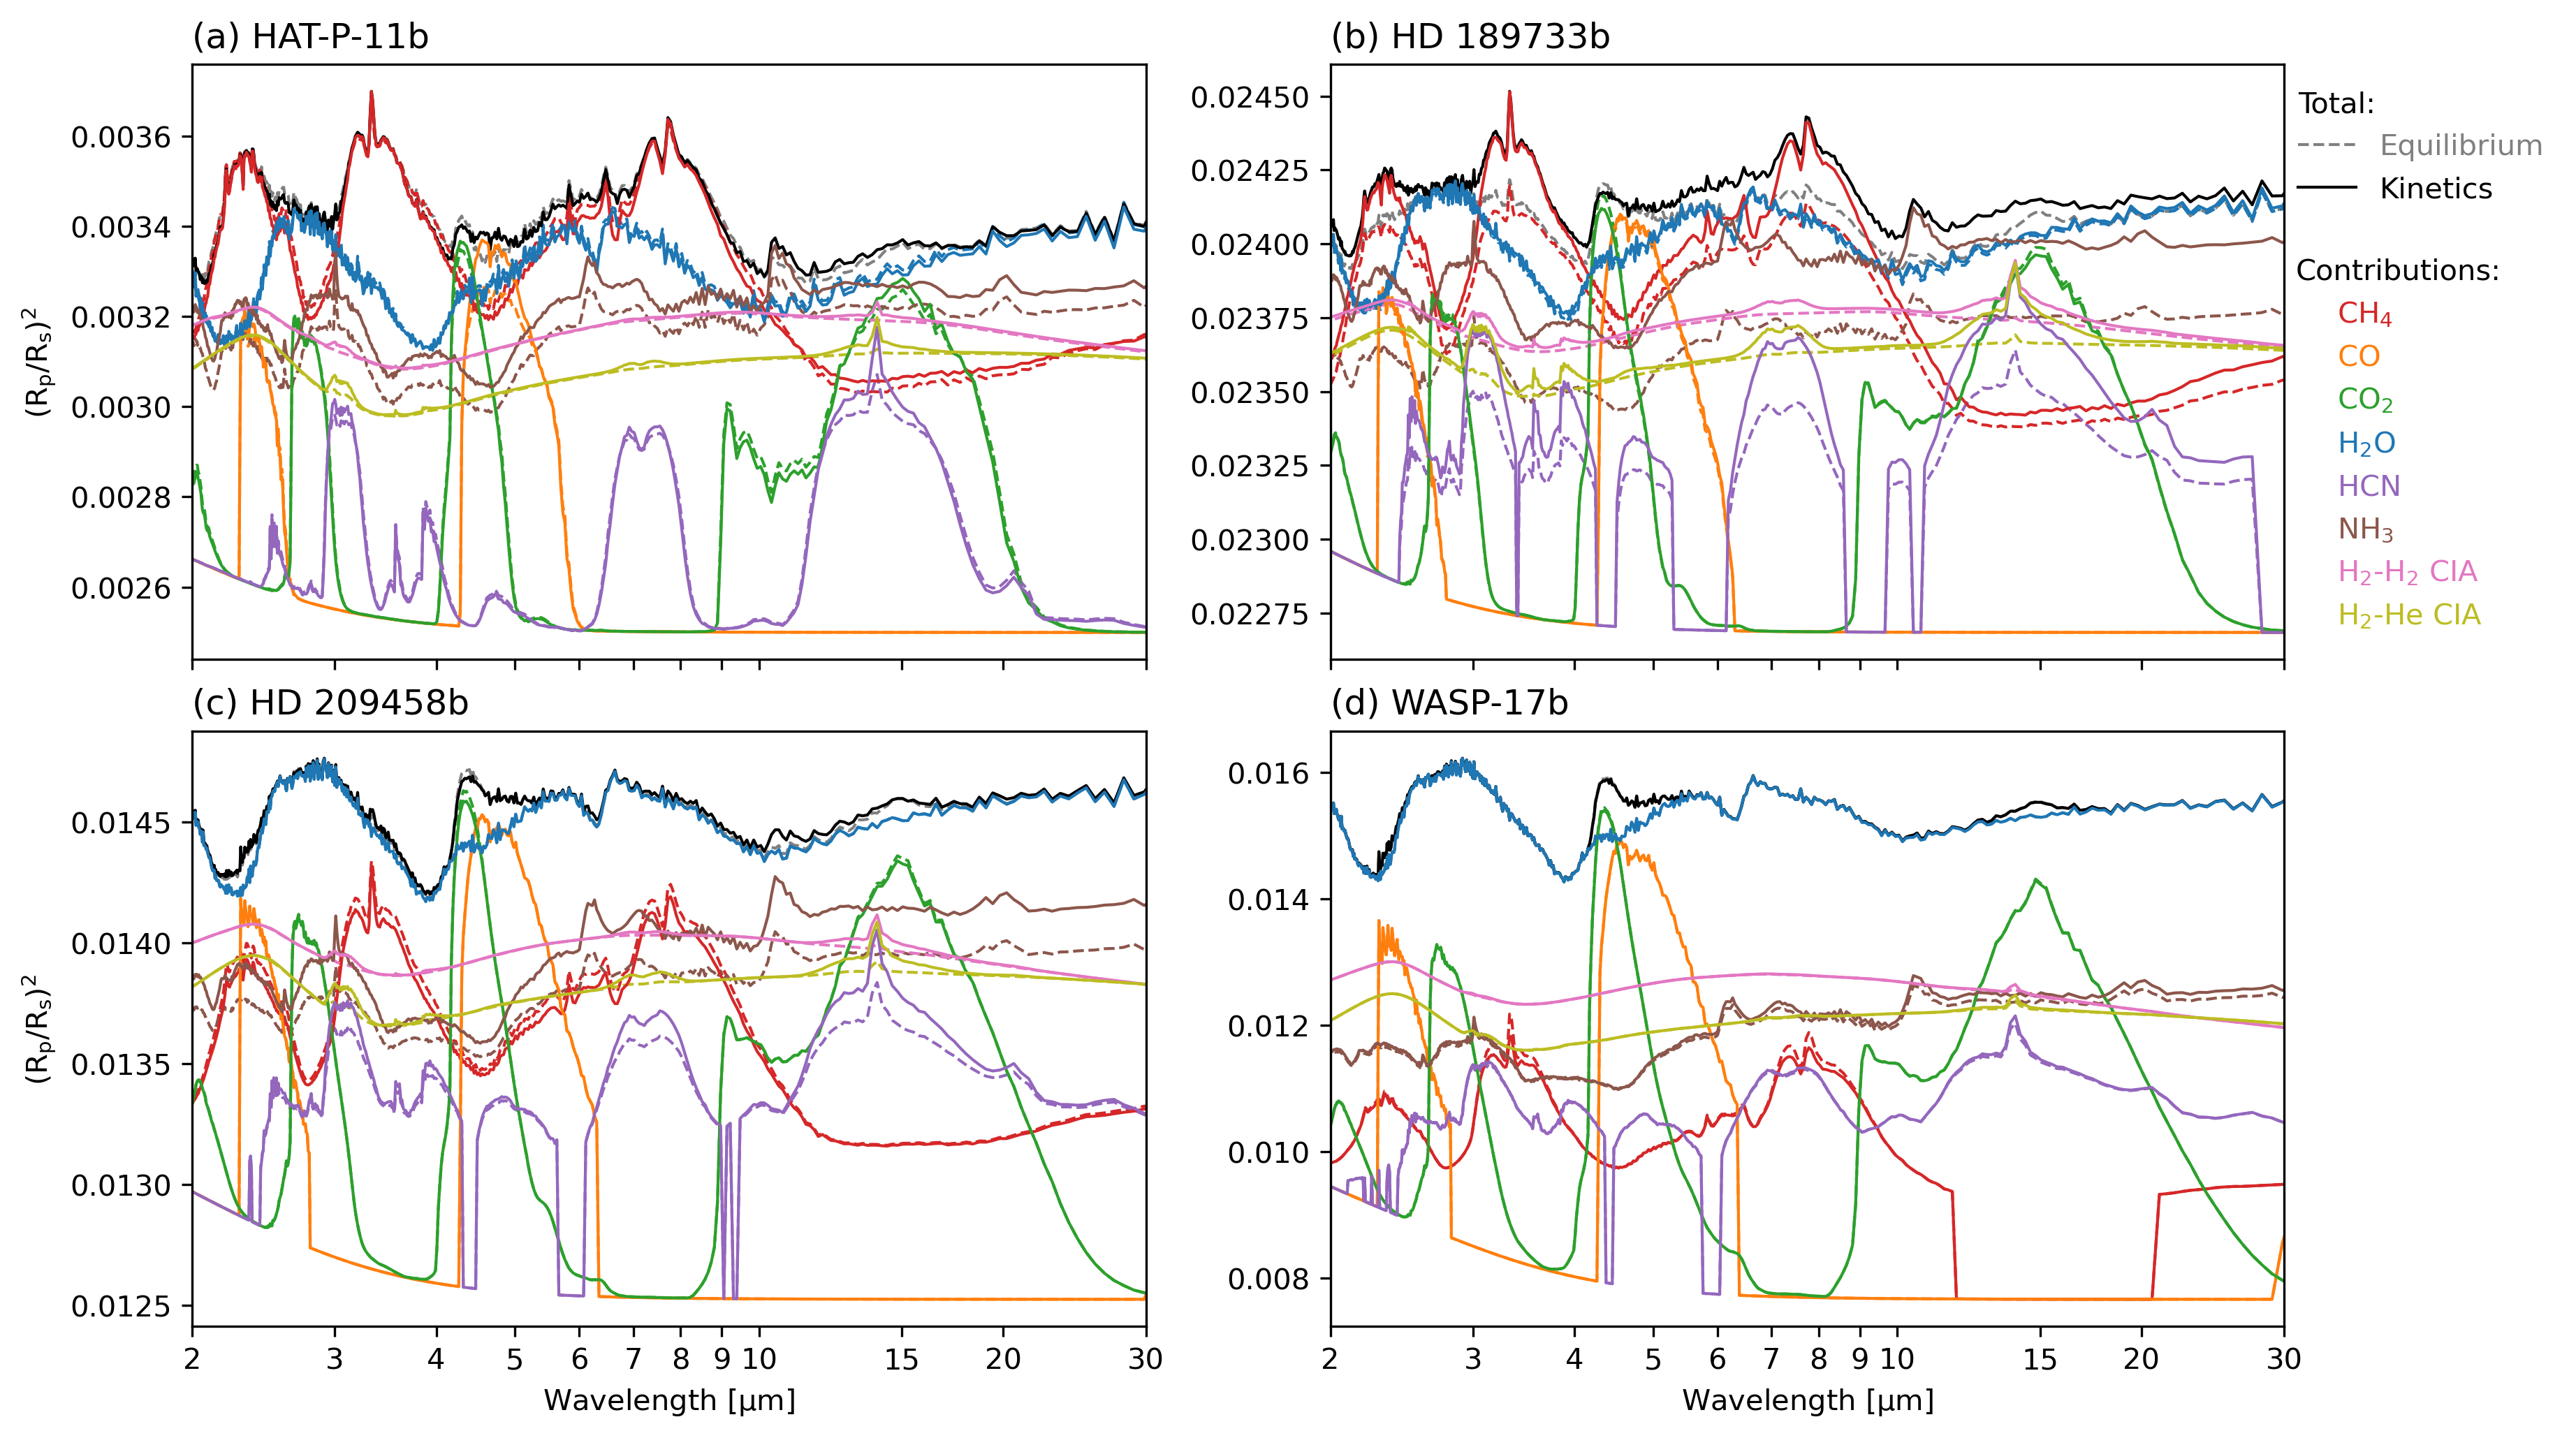

In [16]:
plt_all = True  # plot total and contributions

# Plot UM total transmission spectra and contributions from individual gases
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6.75), constrained_layout=True, sharex=True)
iletters = subplot_label_generator()
for planet, ax in zip(PLANETS.keys(), axes.flatten()):
    ax.set_title(f'({next(iletters)}) {PLANETS[planet]["tex"]}', loc="left")

    # Add UM data
    for exp, linestyle in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
        for sp in sps:
            spectral_band_centers = vrbls[planet][exp]["total"]["spectral_band_centers"]
            rp_eff_over_rs = vrbls[planet][exp][sp]["rp_eff_over_rs"]
            if sp == "total":
                if exp == "equilibrium":
                    clr = "grey"
                else:
                    clr = "k"
                lbl = None
            else:
                if sp not in [i.lower() for i in list(GASES.keys())]:
                    clr = CIA[sp]["color"]
                    lbl = CIA[sp]["tex"]
                else:
                    clr = GASES[sp.upper()]["color"]
                    lbl = GASES[sp.upper()]["tex"]
            if plt_all:
                ax.plot(
                    spectral_band_centers * 1e6,
                    rp_eff_over_rs.data.squeeze() ** 2 + plt_kws[planet]["um_shift"],
                    label=lbl,
                    color=clr,
                    linestyle=linestyle,
                    linewidth=1,
                )
            else:
                # Repeated but transparent (!) to save the same y axis limits
                ax.plot(
                    spectral_band_centers * 1e6,
                    rp_eff_over_rs.data.squeeze() ** 2 + plt_kws[planet]["um_shift"],
                    label=lbl,
                    color=clr,
                    linestyle=linestyle,
                    alpha=0,  # transparent
                    linewidth=1,
                )
                if sp in ["co"]:
                    ax.plot(
                        spectral_band_centers * 1e6,
                        rp_eff_over_rs.data.squeeze() ** 2 + plt_kws[planet]["um_shift"],
                        label=lbl,
                        color=clr,
                        linestyle=linestyle,
                        linewidth=1,
                    )
    ax.set_xscale("log")
    ax.set_xlim(2, 30)  # (0.5, 7.8) Ariel, 0.6, 28.3 JWST
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Wavelength [$\mu$m]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("($R_p/R_s)^2$")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)  # comment out when using widgets

# Add experiments legend
leg_exp_styles = {
    "equilibrium".capitalize(): {"linestyle": "dashed", "linewidth": 1, "color": "grey"},
    "kinetics".capitalize(): {"linestyle": "solid", "linewidth": 1, "color": "k"},
}
leg_exp_kw = {
    "frameon": False,
    "loc": "upper right",
    "bbox_to_anchor": (1.3, 1),
    "title": "Total:",
}
lines_exp = [Line2D([0], [0], **style) for style in leg_exp_styles.values()]
leg_exp = axes[0, 1].legend(lines_exp, leg_exp_styles.keys(), **leg_exp_kw)
if axes[0, 1].legend_ is not None:
    axes[0, 1].add_artist(leg_exp)
for line, text in zip(leg_exp.get_lines(), leg_exp.get_texts()):
    text.set_color(line.get_color())
leg_exp._legend_box.align = "left"

# Add species legend (delete repeating handles and labels)
handles, labels = plt.gca().get_legend_handles_labels()
i = 1
while i < len(labels):
    if labels[i] in labels[:i]:
        del labels[i]
        del handles[i]
    else:
        i += 1
leg_sp = axes[0, 1].legend(
    handles,
    labels,
    frameon=False,
    loc="upper right",
    bbox_to_anchor=(1.255, 0.72),
    handlelength=0,
    title="Contributions:",
)
for line, text in zip(leg_sp.get_lines(), leg_sp.get_texts()):
    text.set_color(line.get_color())
leg_sp.get_title().set_position((0, 0))

figname = f"transmission_daynight_2_30_micron_total_w_contributions_w_cia.png"
fig.savefig(path_to_results / "synthetic_observations" / "transmission_spectrum" / figname)

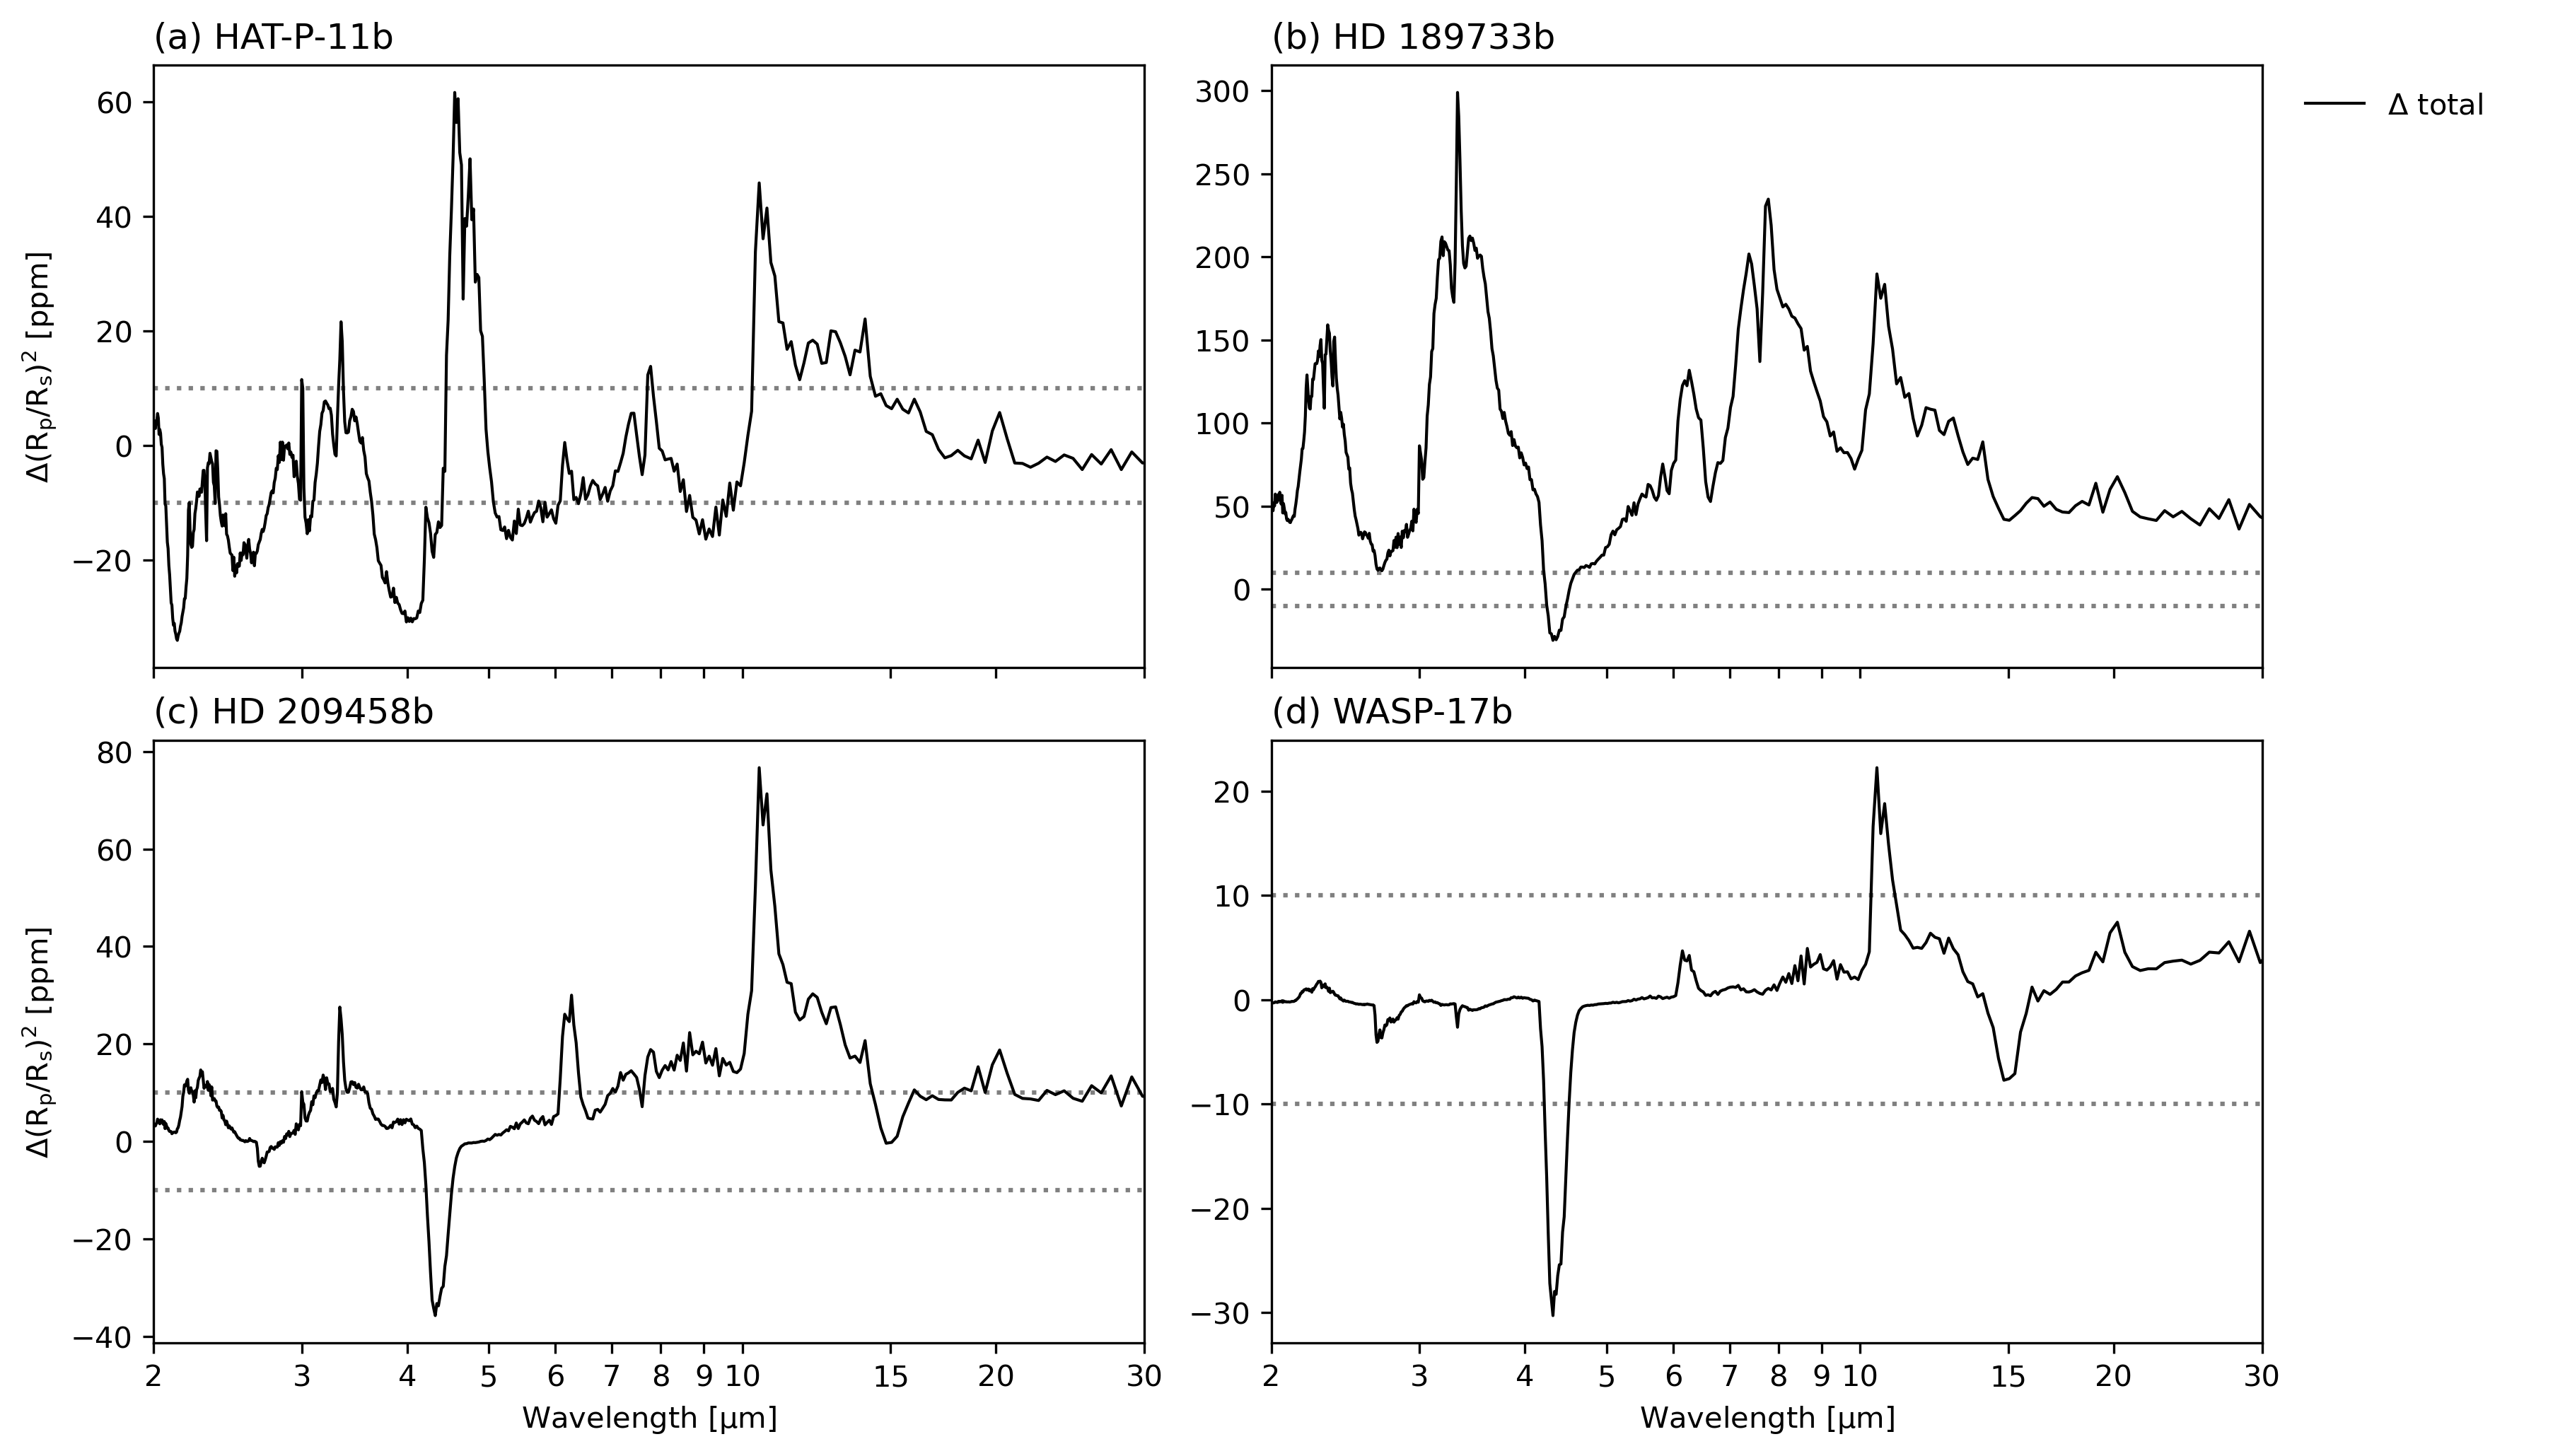

In [17]:
plt_all = False  # plot differences in totals (and contributions)

# Plot differences in UM total transmission spectra and contributions from individual gases
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6.75), constrained_layout=True, sharex=True)
iletters = subplot_label_generator()
for planet, ax in zip(PLANETS.keys(), axes.flatten()):
    ax.set_title(f'({next(iletters)}) {PLANETS[planet]["tex"]}', loc="left")
    ax.axhline(y=10, color="grey", linestyle="dotted")
    ax.axhline(y=-10, color="grey", linestyle="dotted")

    # Add UM data
    for sp in sps:
        spectral_band_centers = vrbls[planet][exp]["total"]["spectral_band_centers"]
        rp_eff_over_rs_equ = vrbls[planet]["equilibrium"][sp]["rp_eff_over_rs"].data.squeeze() ** 2
        rp_eff_over_rs_kin = vrbls[planet]["kinetics"][sp]["rp_eff_over_rs"].data.squeeze() ** 2
        rp_eff_over_rs_diff = (rp_eff_over_rs_kin - rp_eff_over_rs_equ) * 1e6  # convert to ppm
        if sp == "total":
            clr = "k"
            lbl = None
            linewidth = 2
        else:
            if sp not in [i.lower() for i in list(GASES.keys())]:
                clr = CIA[sp]["color"]
                lbl = CIA[sp]["tex"]
            else:
                clr = GASES[sp.upper()]["color"]
                lbl = GASES[sp.upper()]["tex"]
            linewidth = 1
        if plt_all:
            ax.plot(
                spectral_band_centers * 1e6,
                rp_eff_over_rs_diff,
                label=lbl,
                color=clr,
                linestyle="solid",
                linewidth=linewidth,
            )
        else:
            #             # Repeated but transparent (!) to save the same y axis limits
            #             ax.plot(
            #                 spectral_band_centers * 1e6,
            #                 rp_eff_over_rs_diff,
            #                 label=lbl,
            #                 color=clr,
            #                 linestyle=linestyle,
            #                 alpha=0,  # transparent
            #                 linewidth=linewidth,
            #             )
            if sp in ["total"]:
                ax.plot(
                    spectral_band_centers * 1e6,
                    rp_eff_over_rs_diff,
                    label=lbl,
                    color=clr,
                    linestyle=linestyle,
                    linewidth=1,
                )
    ax.set_xscale("log")
    ax.set_xlim(2, 30)  # (0.5, 7.8) Ariel, 0.6, 28.3 JWST
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Wavelength [$\mu$m]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("$\Delta$($R_p/R_s)^2$ [ppm]")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)  # comment out when using widgets

# Add experiments legend
leg_exp_styles = {
    "$\Delta$ total": {"linestyle": "solid", "linewidth": 1, "color": "k"},
}
leg_exp_kw = {
    "frameon": False,
    "loc": "upper right",
    "bbox_to_anchor": (1.25, 1),
    #     "title": "Total:",
}
lines_exp = [Line2D([0], [0], **style) for style in leg_exp_styles.values()]
leg_exp = axes[0, 1].legend(lines_exp, leg_exp_styles.keys(), **leg_exp_kw)
if axes[0, 1].legend_ is not None:
    axes[0, 1].add_artist(leg_exp)
for line, text in zip(leg_exp.get_lines(), leg_exp.get_texts()):
    text.set_color(line.get_color())
leg_exp._legend_box.align = "left"

# Add species legend (delete repeating handles and labels)
handles, labels = plt.gca().get_legend_handles_labels()
i = 1
while i < len(labels):
    if labels[i] in labels[:i]:
        del labels[i]
        del handles[i]
    else:
        i += 1
leg_sp = axes[0, 1].legend(
    handles,
    labels,
    frameon=False,
    loc="upper right",
    bbox_to_anchor=(1.3, 0.92),
    handlelength=0,
    #     title="$\Delta$ contributions:",
)
for line, text in zip(leg_sp.get_lines(), leg_sp.get_texts()):
    text.set_color(line.get_color())
leg_sp.get_title().set_position((0, 0))

figname = f"transmission_daynight_2_30_micron_total_diff.png"
fig.savefig(path_to_results / "synthetic_observations" / "transmission_spectrum" / figname)